In [1]:
!wget https://ss-takashi.sakura.ne.jp/corpus/jvnv/jvnv_ver1.zip

--2025-12-05 18:57:34--  https://ss-takashi.sakura.ne.jp/corpus/jvnv/jvnv_ver1.zip
ss-takashi.sakura.ne.jp (ss-takashi.sakura.ne.jp) をDNSに問いあわせています... 219.94.162.51
ss-takashi.sakura.ne.jp (ss-takashi.sakura.ne.jp)|219.94.162.51|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 1778635432 (1.7G) [application/zip]
`jvnv_ver1.zip' に保存中

jvnv_ver1.zip       100%[===================>]   1.66G  1.91MB/s 時間 17m 40s    

2025-12-05 19:15:14 (1.60 MB/s) - `jvnv_ver1.zip' へ保存完了 [1778635432/1778635432]



In [2]:
!unzip jvnv_ver1.zip

Archive:  jvnv_ver1.zip
   creating: jvnv_v1
  inflating: jvnv_v1/transcription.pdf  
   creating: jvnv_v1/F1
   creating: jvnv_v1/F1/surprise
   creating: jvnv_v1/F1/surprise/free
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_08.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_10.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_06.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_04.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_02.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_05.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_09.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_03.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_01.wav  
  inflating: jvnv_v1/F1/surprise/free/F1_surprise_free_07.wav  
   creating: jvnv_v1/F1/surprise/regular
  inflating: jvnv_v1/F1/surprise/regular/F1_surprise_regular_51.wav  
  inflating: jvnv_v1/F1/surprise/regular/F1_surprise_regular_50.wav 

In [3]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from pickle import FRAME

In [4]:
# ------------------------------------------------------------
# 音声読み込み
# ------------------------------------------------------------
# sr=None とすることで、ファイルが元々持っているサンプリング周波数をそのまま使う。
# ここでは感情音声コーパス jvnv_v1 の「悲しみ / 通常発話」M2話者の 43 番目のファイルを読み込んでいる。
yA, sr = librosa.load("jvnv_v1/M2/sad/regular/M2_sad_regular_43.wav", sr=None)

# ------------------------------------------------------------
# VAD（Voice Activity Detection: 音声区間検出）の閾値・フレーム条件
# ------------------------------------------------------------
# VAD_THRESHOLD_RMS:
#   1フレームの実効値（RMS: root mean square）がこの値を超えたら
#   「有声（音がある）」と判定するための閾値。
#   単位は波形振幅のスケール（librosa のデフォルト：-1〜1）に依存する。
VAD_THRESHOLD_RMS = 0.01

# VAD_THRESHOLD_NORM_RMS:
#   正規化された RMS に対する閾値候補（例示としてコメントアウトされている）。
#   フレームごとの RMS を何らかの基準で正規化してから閾値判定したい場合に使える。
# VAD_THRESHOLD_NORM_RMS = 0.05

# FRAME_LENGTH:
#   1フレームの長さを「0.1 秒 × サンプリング周波数」で定義している。
#   例: sr=16000 の場合 → 1600 サンプル ≒ 100 ms。
FRAME_LENGTH = int(0.1 * sr)

# FRAME_SHIFT:
#   連続するフレームの開始位置のシフト量（サンプル数）。
#   ここでは固定値 256 サンプル（sr=16kHz なら約 16ms）で、フレーム長よりも短いためオーバーラップ分析になる。
FRAME_SHIFT = 256

# FRAME_SHIFT_SEC:
#   シフト量を秒単位で表したもの。時間軸にプロットするときなどに便利。
FRAME_SHIFT_SEC = FRAME_SHIFT / sr

# SILENCE_THRESHOLD_FRAMES:
#   「何フレーム連続で無音が続いたら本当に無音区間とみなすか」の閾値例。
#   ここでは 10 フレーム（≈ 10×16ms ≒ 160ms）分の無音が続いたら
#   1 つの無音区間として扱う、というような使い方を想定している。
SILENCE_THRESHOLD_FRAMES = 10


# ------------------------------------------------------------
# VAD のメイン処理
# ------------------------------------------------------------
# 与えられた波形 y をフレームごとに分割し、各フレームの RMS を計算して
# 閾値との比較で「有声(True) / 無声(False)」のフラグ列を返す。
def calculate_vad(y, threshold, frame_length, frame_shift):
    # 全体のサンプル長から、何フレーム取れるかを計算
    # （端数は切り捨て。端の余りサンプルは無視する簡易実装）
    frame_count = int(len(y) / frame_shift)

    # フレームごとの VAD 判定結果(True/False)を入れるリスト
    vad = []

    # 各フレームごとに RMS を計算して、閾値と比較する
    for f in range(frame_count):
        # f 番目のフレームの開始〜終了インデックスを算出
        start = f * frame_shift
        end = f * frame_shift + frame_length

        # 波形がフレーム長よりも短くなっている場合は、そのまま切り出す
        # （end が len(y) を超えるときは、NumPy のスライス仕様により自動的に末尾で切れる）
        frame = y[start:end]

        # フレーム内 RMS を計算
        #   rms = sqrt( (1/N) * Σ frame[n]^2 )
        # となっており、振幅の「平均的な大きさ」を表す指標になっている。
        if len(frame) > 0:
            rms = np.sqrt(np.mean(frame**2))
        else:
            # フレーム長が 0（ありえないはずだが安全のため）の場合は 0 とみなす
            rms = 0.0

        # 閾値より大きければ「音声あり」と判定
        # → True: 有声 / False: 無声
        vad.append(True if rms > threshold else False)

    # 各フレームごとの VAD 判定結果（長さ frame_count の True/False リスト）を返す
    return vad


# ------------------------------------------------------------
# 実データに対する VAD の実行
# ------------------------------------------------------------
# 上で定義した calculate_vad を用いて、読み込んだ音声 yA に対して
# 「フレームごとの有声/無声フラグ列」を計算する。
# ここで得られる vad は、例えば
# - 有声区間の時間範囲を抽出する
# - スペクトログラムや F0 を「有声部分だけ」プロットする
# といった用途にそのまま使える。
vad = calculate_vad(yA, VAD_THRESHOLD_RMS, FRAME_LENGTH, FRAME_SHIFT)

In [5]:
def identify_silence(vad, silence_threshold_frames):
    # 無音区間の開始インデックスを格納するリスト
    silence_beg = []
    # 無音区間の終了インデックスを格納するリスト
    silence_end = []
    # 現在「無音が連続しているかどうか」を表すカウンタ
    # 0：直前が「音声」（またはまだ何も始まっていない）
    # >0：無音フレームが続いている最中
    sil_counter = 0

    # フレームごとに VAD 結果を走査
    # i: フレームインデックス, v: そのフレームの VAD 結果 (True=音声, False=無音)
    for i, v in enumerate(vad):
        if v:
            # v が True →「音声フレーム」
            if sil_counter > 0:
                # 直前まで無音が続いていた場合、その無音区間がここで終了する
                # 無音区間の「終了インデックス」として現在のフレーム i を記録
                silence_end.append(i)
                # 無音カウンタをリセット（ここからは「音声」区間）
                sil_counter = 0
        else:
            # v が False →「無音フレーム」
            if sil_counter == 0:
                # 直前までは音声だったが、ここから無音が始まる場合
                # 無音区間の「開始インデックス」として i を記録
                silence_beg.append(i)
                # 無音カウンタを 1 にして「無音区間に入った」ことを示す
                sil_counter += 1
            # すでに無音中（sil_counter > 0）の場合は、
            # ここではカウンタを増やしていないため「無音が続いている」ことだけを表現している

    # ループ終了後、最後まで無音が続いていた場合には
    # 最終フレームの「次のインデックス」を無音区間の終了として追加する
    if sil_counter > 0:
        silence_end.append(i + 1)

    # 無音区間の開始・終了インデックスリストを返す
    return silence_beg, silence_end


def compute_speech_intervals(
    silence_beg, silence_end, silence_threshold_frames, FRAME_SHIFT_SEC
):
    # （ここでは変数名 ipu_* だが）無音区間の開始・終了時刻を秒単位で格納するリスト
    ipu_beg_ms = []
    ipu_end_ms = []
    # 処理した無音区間の数をカウントする変数
    sil_counter = 0

    # 無音区間の開始・終了インデックスのペアごとに処理
    for beg, end in zip(silence_beg, silence_end):
        # この無音区間のフレーム長（end - beg）が閾値より長い場合，
        # 「十分に長い無音」とみなしてその開始・終了を時間で記録する
        if end - beg > silence_threshold_frames:
            # フレームインデックス → 秒に変換（FRAME_SHIFT_SEC は 1 フレームあたりの秒数）
            ipu_beg_ms.append(beg * FRAME_SHIFT_SEC)
            ipu_end_ms.append(end * FRAME_SHIFT_SEC)
            sil_counter += 1
            # この無音区間については処理完了なので次へ進む
            continue
        # 無音区間が短く、かつ発話の先頭から始まっている場合の特別扱い
        elif beg == 0:
            # ここでは 0〜0 秒の「無音（または境界）」として扱っている
            # （IPU の定義次第では、この部分はロジックを見直す余地がある）
            ipu_beg_ms.append(0)
            ipu_end_ms.append(0)
        sil_counter += 1

    # ループ内で一度も長い無音区間が検出されなかった場合のフォールバック
    # （silence_beg/silence_end が空、あるいはすべてが閾値以下だったケース）
    if sil_counter == 0:
        # end は for ループ外では定義されない可能性があるため、
        # 実運用ではここに到達しない設計にするか、別の値を使うほうが安全
        # ここでは「最後のフレーム位置」をそのまま開始・終了として記録している想定
        ipu_beg_ms.append(end * FRAME_SHIFT_SEC)
        ipu_end_ms.append(end * FRAME_SHIFT_SEC)

    # 無音区間（あるいは IPU 境界候補）の開始・終了時刻のリストを返す
    return ipu_beg_ms, ipu_end_ms


# VAD の結果（True/False のフレーム列）から、無音区間の開始・終了インデックスを取得
silence_beg, silent_end = identify_silence(vad, SILENCE_THRESHOLD_FRAMES)

# 上で検出した無音区間から、秒単位の区間情報を計算
# - silence_threshold_frames: 「何フレーム以上連続していたら無音とみなすか」の閾値
# - FRAME_SHIFT_SEC: フレームシフト長（秒）
ipu_beg_sec, ipu_end_sec = compute_speech_intervals(
    silence_beg,
    silent_end,
    SILENCE_THRESHOLD_FRAMES,
    FRAME_SHIFT_SEC,
)

# 検出された無音（あるいは IPU 境界）の開始・終了時刻を秒単位で表示
print(ipu_beg_sec)
print(ipu_end_sec)

[0.0, 0.8906666666666666, 3.1466666666666665, 5.061333333333333, 5.386666666666667]
[0.5973333333333333, 1.888, 3.957333333333333, 5.1306666666666665, 6.256]


In [6]:
def identify_silence(vad, silence_threshold_frames):
    """
    VAD 結果（True: 音声, False: 無音）の 1 次元配列から，
    「連続する無音区間」の開始フレーム index と終了フレーム index を抽出する関数。

    Parameters
    ----------
    vad : list[bool] or np.ndarray[bool]
        フレームごとの VAD 結果（True: 音声, False: 無音）
    silence_threshold_frames : int
        現状この関数内では **未使用**。
        無音区間の長さフィルタは呼び出し側（compute_speech_intervals）で行っている。

    Returns
    -------
    silence_beg : list[int]
        無音区間の開始フレーム index（含む）
    silence_end : list[int]
        無音区間の終了フレーム index（含まない, Python のスライスの終端イメージ）
    """
    silence_beg = []  # 無音区間の開始フレーム index を格納するリスト
    silence_end = []  # 無音区間の終了フレーム index を格納するリスト
    sil_counter = 0  # 「今、無音区間の中にいるかどうか」を示すフラグ (0: 外, >0: 中)

    # フレームごとに VAD (v) を走査
    for i, v in enumerate(vad):
        if v:
            # v が True → 有声音フレーム
            if sil_counter > 0:
                # 直前まで無音区間だった場合、その無音区間がここで終了する
                silence_end.append(
                    i
                )  # 終了フレーム index（このフレーム i は無音ではないので含めない）
                sil_counter = 0  # 無音状態フラグをリセット
        else:
            # v が False → 無声音フレーム
            if sil_counter == 0:
                # 直前まで有声音だった場合，新たな無音区間がここから始まる
                silence_beg.append(i)  # 無音区間の開始フレーム index
                sil_counter += (
                    1  # 無音状態に入ったことを示すフラグ（1以上になれば「無音中」）
                )

    # ループ終了時点でまだ無音区間の途中であれば，
    # その無音区間は信号末尾まで続いているとみなして end を追加する
    if sil_counter > 0:
        silence_end.append(
            i + 1
        )  # i は最後の index なので，スライス終端を表す i+1 を入れておく

    return silence_beg, silence_end


def compute_speech_intervals(
    silence_beg, silence_end, silence_threshold_frames, FRAME_SHIFT
):
    """
    無音区間の開始・終了 index から，
    「ある程度以上長い無音区間」を抽出し，
    その開始・終了をフレーム単位で返す関数。

    ※現在の実装では，長い無音区間そのものの区間を返している点に注意。
      IPU（発話区間）ではなく「区切りとして使える無音区間の候補」を返す設計になっている。

    Parameters
    ----------
    silence_beg : list[int]
        無音区間の開始フレーム index
    silence_end : list[int]
        無音区間の終了フレーム index（スライス終端）
    silence_threshold_frames : int
        「このフレーム数より長い無音区間だけを有効なサイレンスとみなす」というしきい値
    FRAME_SHIFT : int
        フレームシフトのサンプル数。
        ここでは単純に「index * FRAME_SHIFT」を返しているので，
        時間 [秒] に変換するには別途「FRAME_SHIFT / sr」を掛ける必要がある点に注意。

    Returns
    -------
    ipu_beg_ms : list[int or float]
        しきい値以上の長さを持つ無音区間の「開始位置」 (FRAME_SHIFT 単位)
        ※変数名は *_ms だが，現状の値は「サンプル数」に比例しているだけで ms ではない
    ipu_end_ms : list[int or float]
        しきい値以上の長さを持つ無音区間の「終了位置」 (FRAME_SHIFT 単位)
    """
    ipu_beg_ms = []  # ここでは「長い無音区間」の開始位置を格納
    ipu_end_ms = []  # ここでは「長い無音区間」の終了位置を格納

    # 検出された全ての無音区間に対してループ
    for beg, end in zip(silence_beg, silence_end):
        # 無音区間の長さ [フレーム数] がしきい値を超えるかチェック
        if end - beg > silence_threshold_frames:
            # しきい値より長い無音だけを「意味のある休止」とみなして採用
            # 現状はフレーム index に FRAME_SHIFT（サンプル数）を掛けた値を返している。
            # 時間 [秒] で欲しい場合は，呼び出し側で / sr する設計にすると良い。
            ipu_beg_ms.append(beg * FRAME_SHIFT)
            ipu_end_ms.append(end * FRAME_SHIFT)

    return ipu_beg_ms, ipu_end_ms


# VAD 結果から無音区間を検出
silence_beg, silent_end = identify_silence(vad, SILENCE_THRESHOLD_FRAMES)

# 検出された無音区間のうち，「しきい値以上に長い無音」だけを抽出
# （現状の実装では，それらの無音区間の開始・終了位置を返している）
ipu_beg_ms, ipu_end_ms = compute_speech_intervals(
    silence_beg,
    silent_end,
    SILENCE_THRESHOLD_FRAMES,
    FRAME_SHIFT,
)

# 結果を表示
print(ipu_beg_ms)
print(ipu_end_ms)

[0, 42752, 151040, 242944, 258560]
[28672, 90624, 189952, 246272, 300288]


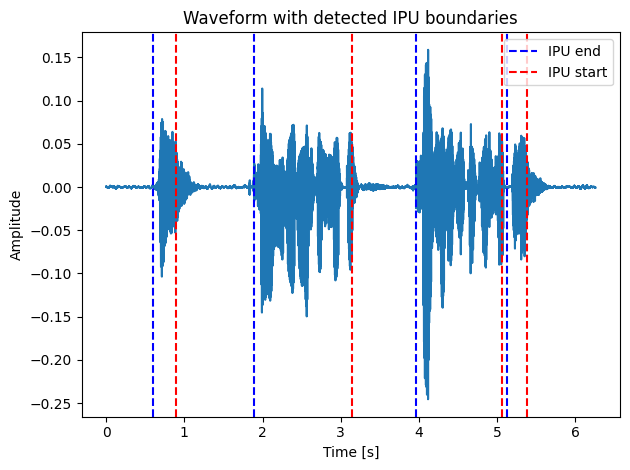

In [7]:
# ------------------------------------------------------------
# IPU（発話区間）境界を時間波形の上にプロットするコード
# ------------------------------------------------------------

# もし前のセルで ipu_beg_ms / ipu_end_ms（サンプル単位 or FRAME_SHIFT 単位）を
# 計算している場合は、まず秒単位に変換しておく。
# - ipu_beg_ms, ipu_end_ms : フレームシフト数 × FRAME_SHIFT [samples]
# - sr : サンプリング周波数 [Hz]
ipu_beg_sec = np.array(ipu_beg_ms) / sr  # サンプルを秒に変換
ipu_end_sec = np.array(ipu_end_ms) / sr  # サンプルを秒に変換

# 時間軸（横軸）を秒単位で作成
# len(yA) サンプル分のインデックスを 0,1,... と並べて sr で割ることで
# t[n] = n / sr となり、「n サンプル目の時刻 [秒]」が得られる。
t = np.arange(len(yA)) / sr

# 図と軸オブジェクトを作成し，音声波形を描画
fig, ax = plt.subplots()
ax.plot(t, yA)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("Waveform with detected IPU boundaries")

# IPU の開始・終了時刻に縦線を描画して，発話の区切りを可視化する。
# ここでは例として
# - 赤の破線 : 発話開始境界（ipu_beg_sec）
# - 青の破線 : 発話終了境界（ipu_end_sec）
# として描いている。
for i in range(len(ipu_beg_sec)):
    # i > 0 のときだけ開始境界を描く:
    #   先頭が 0 秒（録音開始時刻）の場合，そこに線を引くと「常に縦線が立っている」ように見えるので
    #   あえてスキップする意図だと解釈できる。
    if i > 0:
        ax.axvline(
            ipu_beg_sec[i],
            color="r",
            linestyle="--",
            label="IPU start" if i == 1 else None,
        )

    # i < len(ipu_end_sec)-1 のときだけ終了境界を描く:
    #   最後の終了境界が「録音のほぼ末尾」に来る場合，
    #   そこに線を引くと見栄えが悪い／情報量が少ないので省いていると解釈できる。
    if i < len(ipu_end_sec) - 1:
        ax.axvline(
            ipu_end_sec[i],
            color="b",
            linestyle="--",
            label="IPU end" if i == 0 else None,
        )

# 凡例が重複しないように上で label を条件付きで付けているので，
# ここでまとめて凡例を表示する。
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()